# Projet Regression Linéaire

Donnée prise sur : https://carlabelling.ademe.fr/

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from statsmodels.stats.stattools import durbin_watson

## Exploration et Prétraitement des données

### Compréhension de la Structure

In [141]:
df = pd.read_csv('vehicules-commercialises.csv', sep=';')
df.head()

,Marque,Modèle dossier,Modèle commercial,Désignation commerciale,CNIT,Type Variante Version (TVV),Carburant,Hybride,Puissance administrative,Puissance maximale,...,HC,NOx,HC+NOx,Particules,Masse vide euro min,Masse vide euro max,Champ v9,Année,Carrosserie,Gamme
0,CITROEN,C1 5P 1.0i,C1 5P 1.0i,C1 5P 1.0i,MCT1012TR301,MCT1012TR301,Essence,NaN,4.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN
1,TOYOTA,AYGO 3P 1.0 VVT-i,AYGO 3P 1.0 VVT-i,AYGO 3P 1.0 VVT-i,MJT1071V7879,MJT1071V7879,Essence,NaN,4.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN
2,TOYOTA,AYGO 3P 1.0 VVT-i MultiMode,AYGO 3P 1.0 VVT-i MultiMode,AYGO 3P 1.0 VVT-i MultiMode,MJT3071VP115,MJT3071VP115,Essence,NaN,4.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN
3,SMART,SMART FORTWO 1.0L BVM5,SMART FORTWO 1.0L BVM5,SMART FORTWO 1.0L BVM5,MST1001DY331,MST1001DY331,Essence,NaN,4.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN
4,SMART,SMART FORFOUR 1.3L BVA6,SMART FORFOUR 1.3L BVA6,SMART FORFOUR 1.3L BVA6,MST3204C1278,MST3204C1278,Essence,NaN,5.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2008,NaN,NaN


In [142]:
print('Dimension de la dataframe :', df.shape, '\n')
df.info()

Dimension de la dataframe : (305701, 26) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305701 entries, 0 to 305700
Data columns (total 26 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Marque                       305701 non-null  object 
 1   Modèle dossier               305701 non-null  object 
 2   Modèle commercial            305701 non-null  object 
 3   Désignation commerciale      305701 non-null  object 
 4   CNIT                         305689 non-null  object 
 5   Type Variante Version (TVV)  260893 non-null  object 
 6   Carburant                    305701 non-null  object 
 7   Hybride                      159780 non-null  object 
 8   Puissance administrative     301497 non-null  float64
 9   Puissance maximale           301428 non-null  float64
 10  Boîte de vitesse             301538 non-null  object 
 11  Consommation urbaine         301223 non-null  float64
 12  Consommation ex

### Nettoyage des données

In [143]:
df.isnull().sum()

Marque                              0
Modèle dossier                      0
Modèle commercial                   0
Désignation commerciale             0
CNIT                               12
Type Variante Version (TVV)     44808
Carburant                           0
Hybride                        145921
Puissance administrative         4204
Puissance maximale               4273
Boîte de vitesse                 4163
Consommation urbaine             4478
Consommation extra-urbaine       4478
Consommation mixte               4398
CO2                              4398
CO type I                      146611
HC                             268888
NOx                            146611
HC+NOx                         183249
Particules                     155458
Masse vide euro min            145831
Masse vide euro max            145831
Champ v9                       108278
Année                               0
Carrosserie                    166801
Gamme                          166801
dtype: int64

On va ici enlever commencer par supprimer les colonnes CO type I / HC / NOx / HC+NOx / Particules car ce sont des émissions liées mais différentes du CO₂, puis les colonnes CNIT / TVV / Désignation commerciale / Marque / Modèle car ce sont des identifiants ou catégories trop spécifiques.

In [144]:
drops = ('CO type I', 'HC', 'NOx', 'HC+NOx', 'Champ v9', 'Particules', 'CNIT', 'Type Variante Version (TVV)', 'Désignation commerciale', 'Marque', 'Modèle dossier', 'Modèle commercial', 'Gamme', 'Carrosserie')
for drop in drops:
    df = df.drop(drop, axis = 1)

df.isnull().sum()

Carburant                          0
Hybride                       145921
Puissance administrative        4204
Puissance maximale              4273
Boîte de vitesse                4163
Consommation urbaine            4478
Consommation extra-urbaine      4478
Consommation mixte              4398
CO2                             4398
Masse vide euro min           145831
Masse vide euro max           145831
Année                              0
dtype: int64

C:\Users\matys\AppData\Local\Temp\ipykernel_17900\470227958.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  na_counts = df.groupby("Année").apply(lambda x: x.isna().sum())


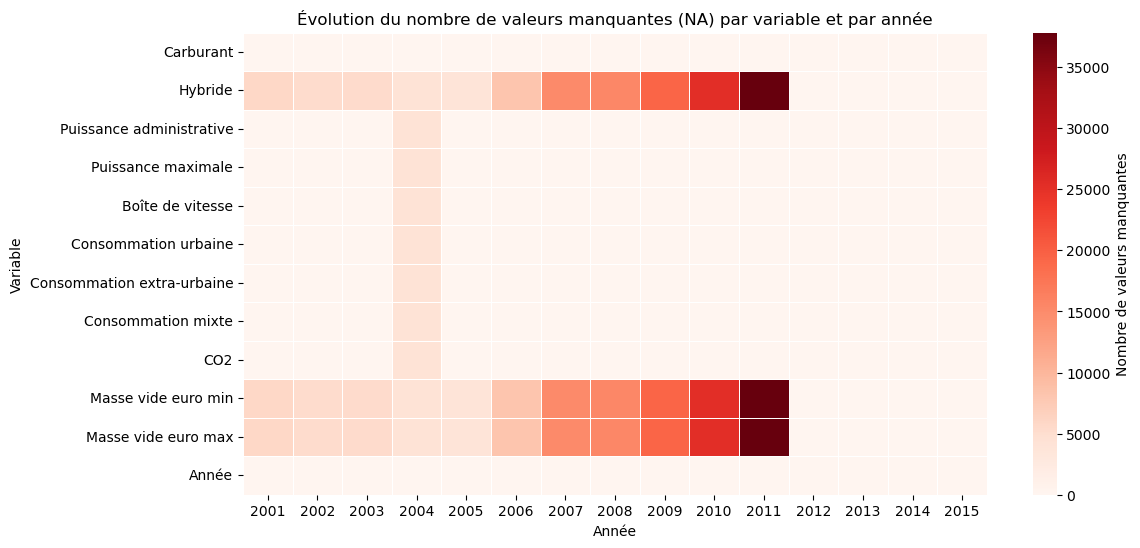

In [145]:
# Vérifier que 'Année' est bien une colonne numérique
df['Année'] = pd.to_numeric(df['Année'], errors='coerce')

# Calculer le nombre de valeurs manquantes par année et par variable
na_counts = df.groupby("Année").apply(lambda x: x.isna().sum())

# Création du graphique
plt.figure(figsize=(12, 6))
sns.heatmap(na_counts.T, cmap="Reds", linewidths=0.5, cbar_kws={'label': 'Nombre de valeurs manquantes'})

plt.xlabel("Année")
plt.ylabel("Variable")
plt.title("Évolution du nombre de valeurs manquantes (NA) par variable et par année")
plt.show()

Ici on peut voir une similitude sur les données manquantes qui ont l'air d'être sur toute les même ligne on devrai donc perdre peu de donnée en les supprimant

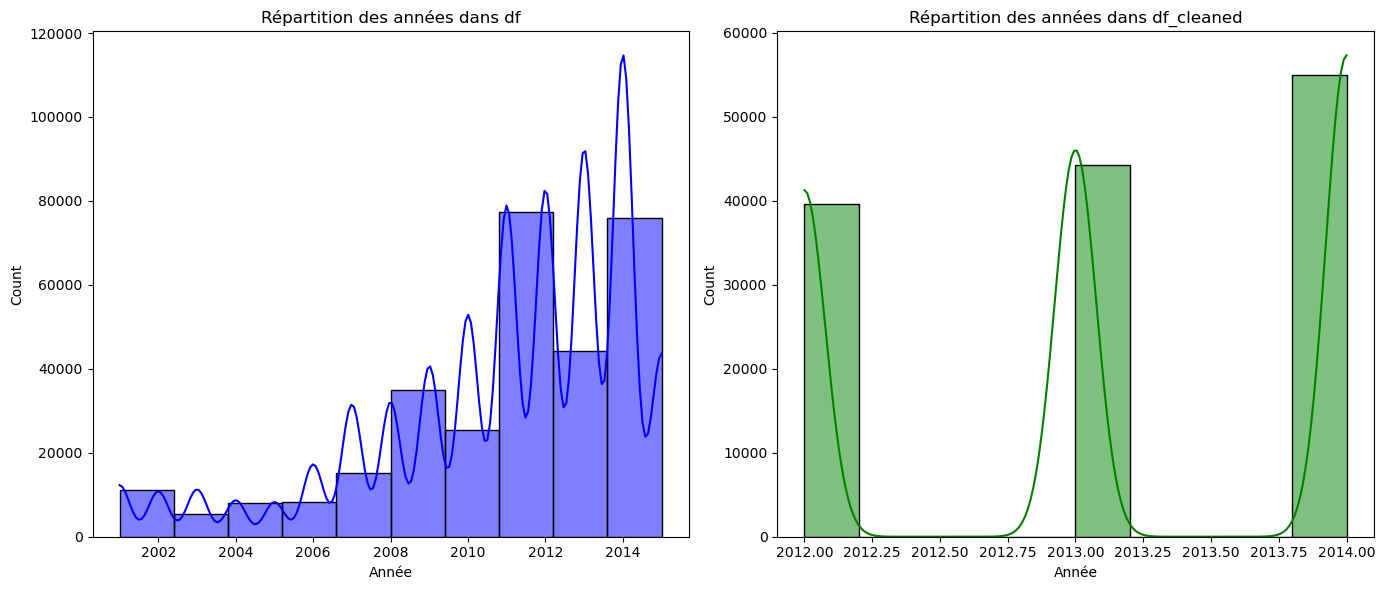

In [146]:
# Création des graphiques
plt.figure(figsize=(14, 6))

# Premier graphique pour df
plt.subplot(1, 2, 1)
sns.histplot(df['Année'], kde=True, color='blue', bins=10)
plt.title('Répartition des années dans df')

# Deuxième graphique pour df_cleaned
plt.subplot(1, 2, 2)
sns.histplot(df_cleaned['Année'], kde=True, color='green', bins=10)
plt.title('Répartition des années dans df_cleaned')

# Afficher les graphiques
plt.tight_layout()
plt.show()

On voit qu'en faisant cela on ne tombe plus que sur des voitures de 2012 2013 et 2014 il va donc falloir trouver une autre solution pour perdre le moins d'information possible

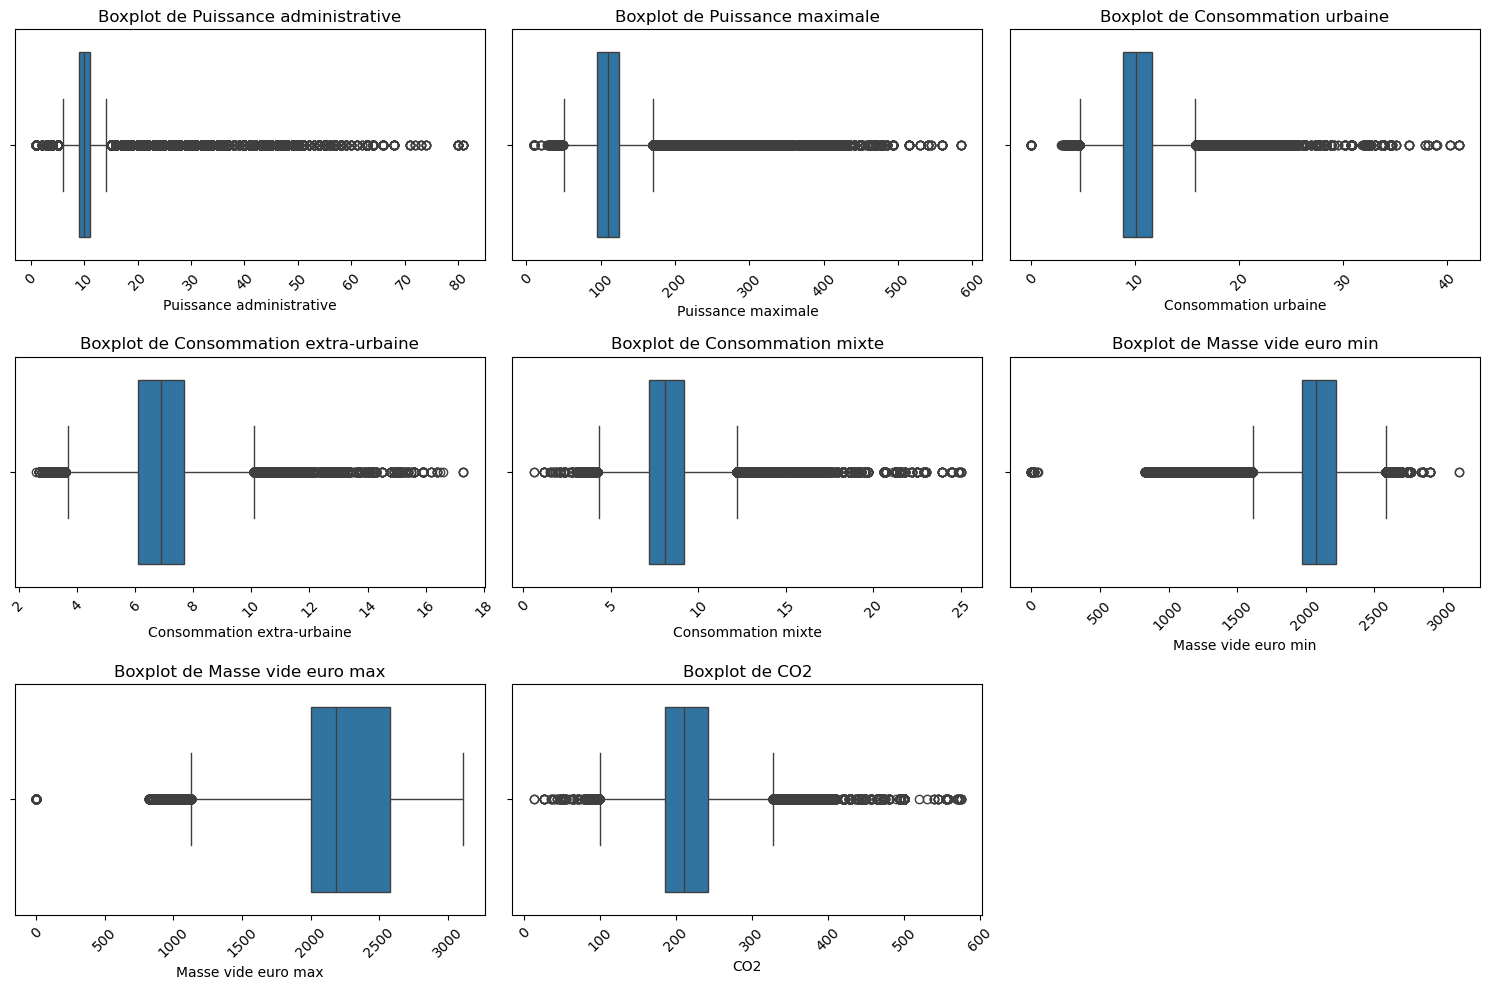

In [147]:
# Sélectionner les variables numériques pour les boxplots
numerical_cols = [
    "Puissance administrative", "Puissance maximale", "Consommation urbaine", 
    "Consommation extra-urbaine", "Consommation mixte", "Masse vide euro min", 
    "Masse vide euro max", "CO2"
]

# Initialiser la figure pour les boxplots
plt.figure(figsize=(15, 10))

# Créer un boxplot pour chaque variable numérique
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)  # Disposition en 3x3
    sns.boxplot(data=df, x=col)
    plt.title(f"Boxplot de {col}")
    plt.xticks(rotation=45)

# Afficher les boxplots
plt.tight_layout()
plt.show()

On peut voir beaucoup de valeur extrème pour chacune des variables on va donc préféré utiliser la médiane pour les valeurs manquantes

In [148]:
# Créer un imputer pour remplir les valeurs manquantes avec la médiane
imputer_num = SimpleImputer(strategy='median')  # Remplir avec la médiane

# Appliquer l'imputation aux colonnes numériques
df[numerical_cols] = imputer_num.fit_transform(df[numerical_cols])

# Vérifier les valeurs manquantes après imputation
print(df.isnull().sum())  # Devrait montrer 0 pour toutes les colonnes numériques

Carburant                          0
Hybride                       145921
Puissance administrative           0
Puissance maximale                 0
Boîte de vitesse                4163
Consommation urbaine               0
Consommation extra-urbaine         0
Consommation mixte                 0
CO2                                0
Masse vide euro min                0
Masse vide euro max                0
Année                              0
dtype: int64


In [149]:
categorical_cols = ["Boîte de vitesse", "Hybride"]
df[categorical_cols] = df[categorical_cols].fillna("Autre")
print(df.isnull().sum())

Carburant                     0
Hybride                       0
Puissance administrative      0
Puissance maximale            0
Boîte de vitesse              0
Consommation urbaine          0
Consommation extra-urbaine    0
Consommation mixte            0
CO2                           0
Masse vide euro min           0
Masse vide euro max           0
Année                         0
dtype: int64


### Analyse exploratoire des données

In [ ]:
# Statistiques descriptives 

print("Statistiques descriptives :")
print(df.describe())

📊 Statistiques descriptives :
       Puissance administrative  Puissance maximale  Consommation urbaine  \
count             305701.000000       305701.000000         305701.000000   
mean                  11.192433          122.163669             10.521886   
std                    6.507268           56.323398              3.235754   
min                    1.000000           10.000000              0.000000   
25%                    9.000000           95.000000              8.800000   
50%                   10.000000          110.000000             10.100000   
75%                   11.000000          125.000000             11.600000   
max                   81.000000          585.000000             41.100000   

       Consommation extra-urbaine  Consommation mixte            CO2  \
count               305701.000000       305701.000000  305701.000000   
mean                     6.884793            8.213086     210.561071   
std                      1.573978            2.137985      5

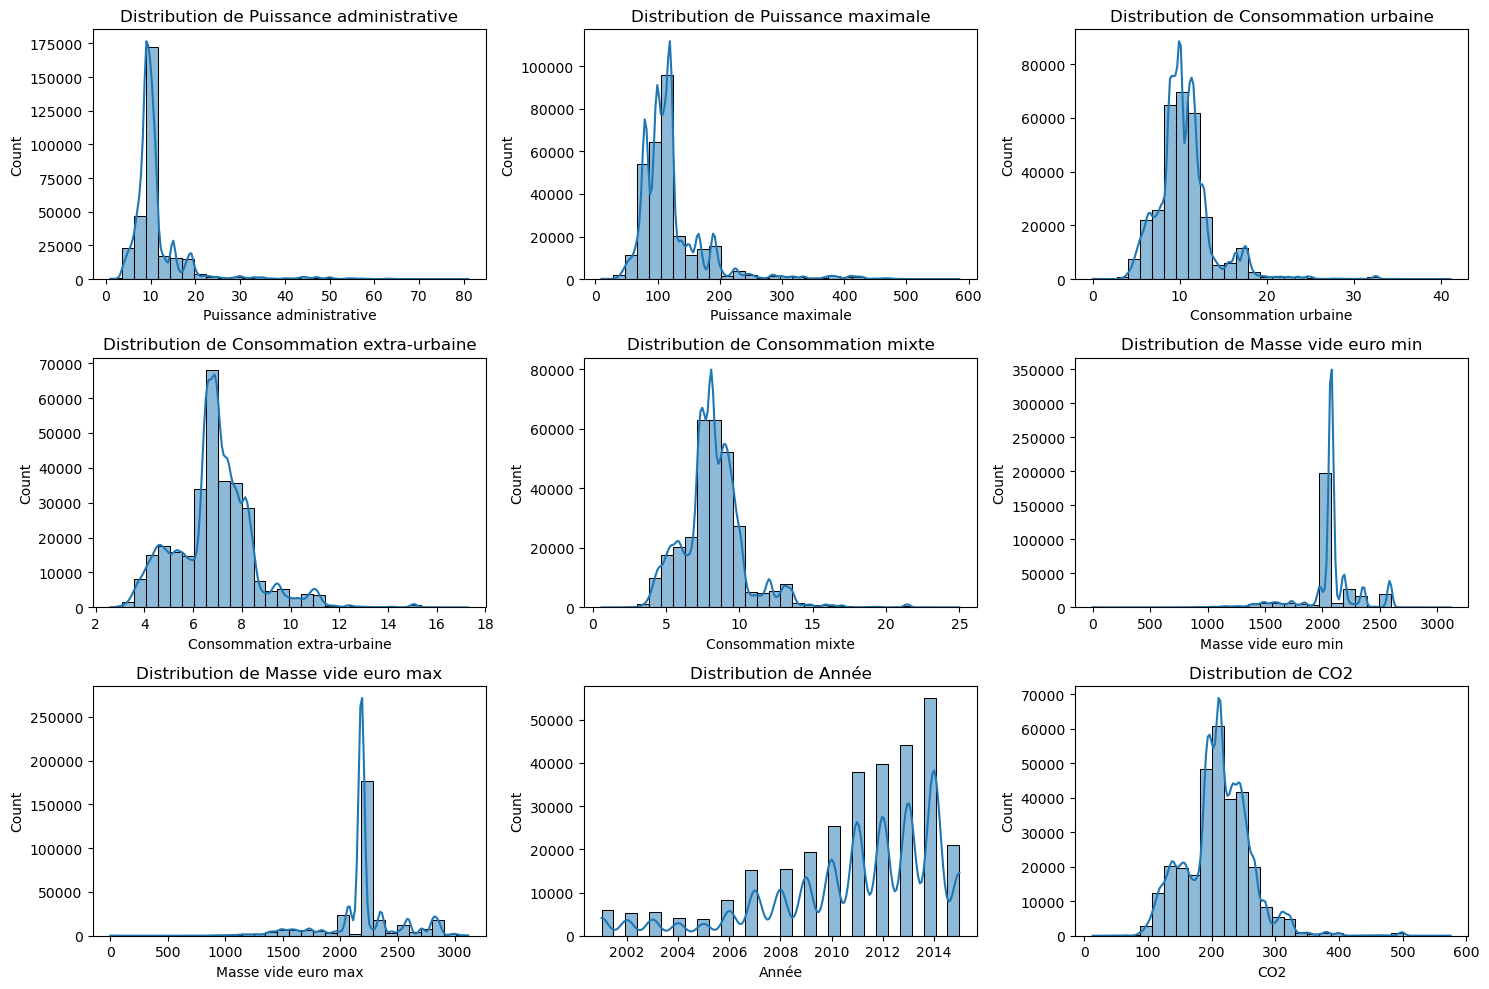

In [151]:
# Histogrammes des variables numériques

numerical_cols = [
    "Puissance administrative", "Puissance maximale", "Consommation urbaine", 
    "Consommation extra-urbaine", "Consommation mixte", "Masse vide euro min", 
    "Masse vide euro max", "Année", "CO2"
]

plt.figure(figsize=(15, 10))
for i, col in enumerate(numerical_cols):
    plt.subplot(3, 3, i + 1)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution de {col}")
plt.tight_layout()
plt.show()

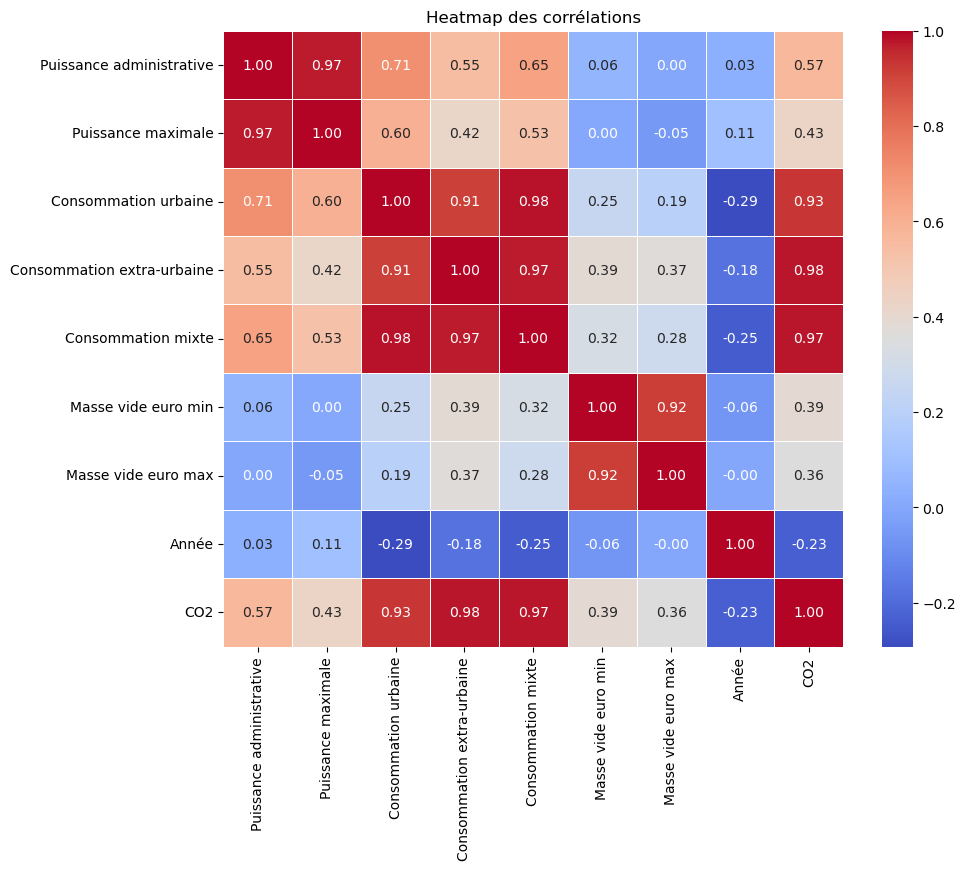

In [138]:
# Matrice de corrélation (heatmap)
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Heatmap des corrélations")
plt.show()

On peut supprimer la consommation urbaine / consommation extra-urbaine car fortement corréler avec consommation mixte de même pourMasse video euro min et max et puissance maximale et puissance administrative 

In [152]:
drops = ('Consommation urbaine', 'Consommation extra-urbaine', 'Puissance maximale', 'Masse vide euro max')
for drop in drops:
    df = df.drop(drop, axis = 1)


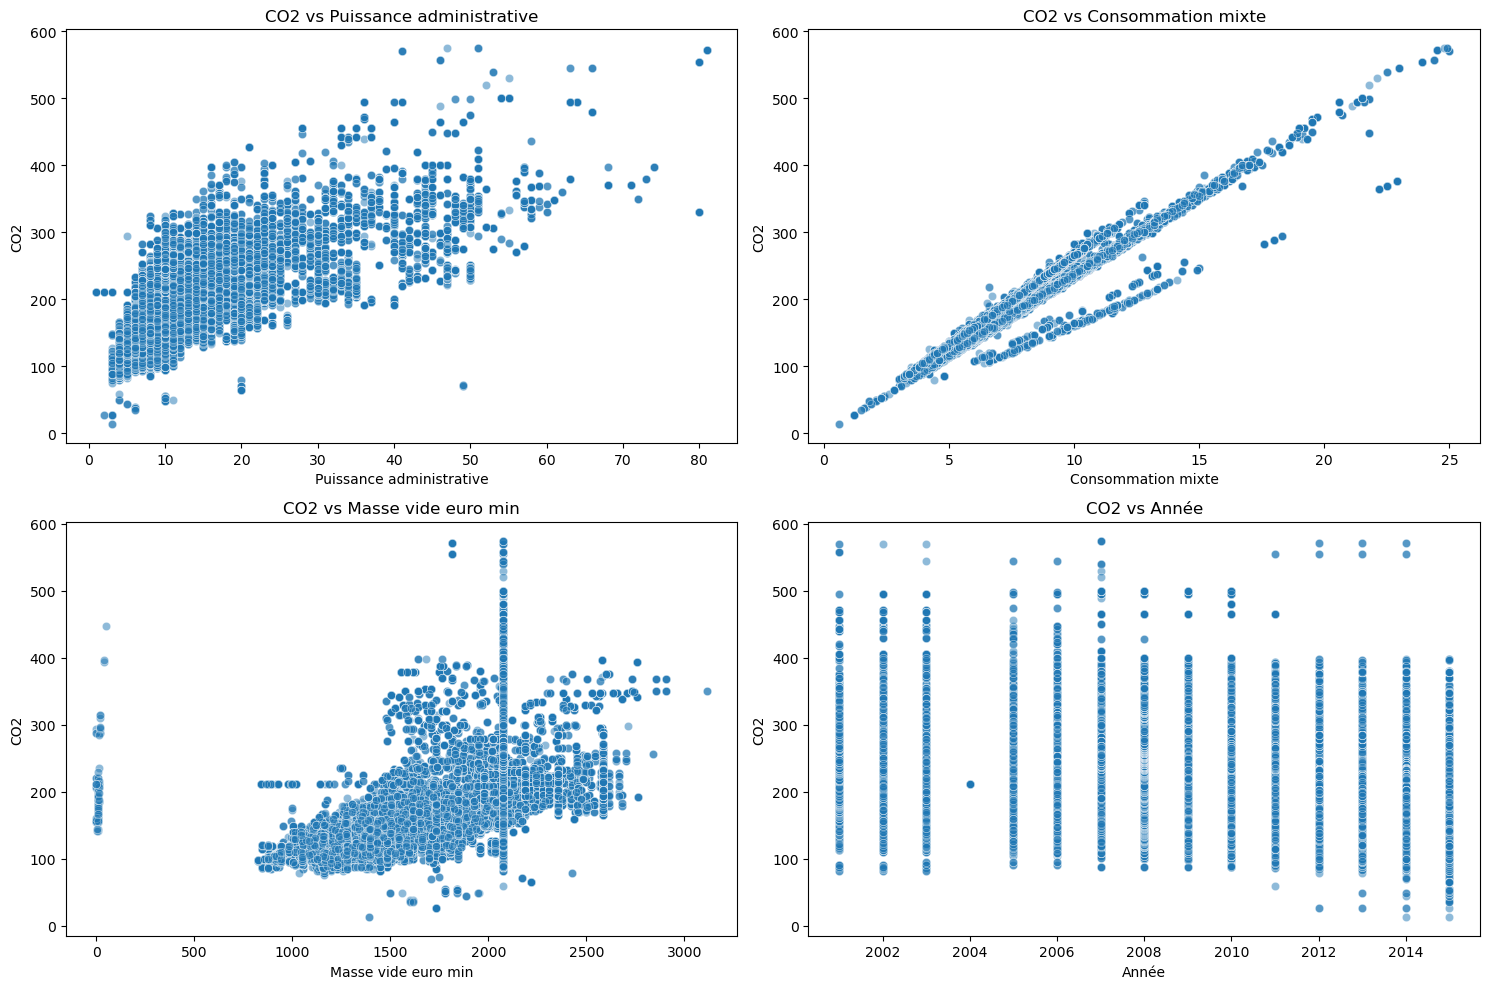

In [154]:
# Scatterplots pour voir la relation entre CO₂ et d'autres variables
variables_explicatives = ["Puissance administrative", "Consommation mixte", "Masse vide euro min", "Année"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(variables_explicatives):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(data=df, x=col, y="CO2", alpha=0.5)
    plt.title(f"CO2 vs {col}")
plt.tight_layout()
plt.show()

## Préparation des données 

### Encodage des variables catégorielles

In [156]:
import pandas as pd

# One-Hot Encoding pour "Carburant" et "Boîte de vitesse"
df = pd.get_dummies(df, columns=["Carburant", "Boîte de vitesse"], drop_first=True)

# Label Encoding pour "Hybride" 
df["Hybride"] = df["Hybride"].map({"Hybre": 1, "Non hybride": 0, "Autre": 0})  # On met "Autre" à 0 par défaut

# Vérification du dataframe après encodage
print(df.head())
print(df.dtypes)  # Vérifier que les variables catégorielles sont bien numériques

   Hybride  Puissance administrative  Consommation mixte    CO2  \
0      0.0                       4.0                 4.6  108.0   
1      0.0                       4.0                 4.6  108.0   
2      0.0                       4.0                 4.6  109.0   
3      0.0                       4.0                 4.7  112.0   
4      0.0                       5.0                 5.6  133.0   

   Masse vide euro min  Année  Carburant_EE  Carburant_EH  Carburant_EL  \
0               2076.0   2008         False         False         False   
1               2076.0   2008         False         False         False   
2               2076.0   2008         False         False         False   
3               2076.0   2008         False         False         False   
4               2076.0   2008         False         False         False   

   Carburant_EN  ...  Boîte de vitesse_M 7  Boîte de vitesse_M5  \
0         False  ...                 False                False   
1         Fa

### Encodages des données

Deux options courantes :

1. Standardisation : Centrer les données (moyenne = 0, écart-type = 1) → Utile si les données suivent une distribution normale.
2. Min-Max Scaling : Mettre les valeurs entre 0 et 1 → Utile si les données ont des échelles différentes et doivent être comparées.

In [159]:
# Sélection des colonnes numériques à normaliser
numerical_cols = [
    "Puissance administrative", "Consommation mixte", "Masse vide euro min", "Année", "CO2"
]

# Appliquer la normalisation Min-Max Scaling
scaler = MinMaxScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

# Vérification du résultat
print(df.head())  # Voir un aperçu des données après normalisation
print(df.describe())  # Vérifier que toutes les valeurs sont entre 0 et 1

   Hybride  Puissance administrative  Consommation mixte       CO2  \
0      0.0                    0.0375            0.163934  0.169039   
1      0.0                    0.0375            0.163934  0.169039   
2      0.0                    0.0375            0.163934  0.170819   
3      0.0                    0.0375            0.168033  0.176157   
4      0.0                    0.0500            0.204918  0.213523   

   Masse vide euro min  Année  Carburant_EE  Carburant_EH  Carburant_EL  \
0             0.666453    0.5         False         False         False   
1             0.666453    0.5         False         False         False   
2             0.666453    0.5         False         False         False   
3             0.666453    0.5         False         False         False   
4             0.666453    0.5         False         False         False   

   Carburant_EN  ...  Boîte de vitesse_M 7  Boîte de vitesse_M5  \
0         False  ...                 False                Fal

## Vérification avant la regression

### Linéarité

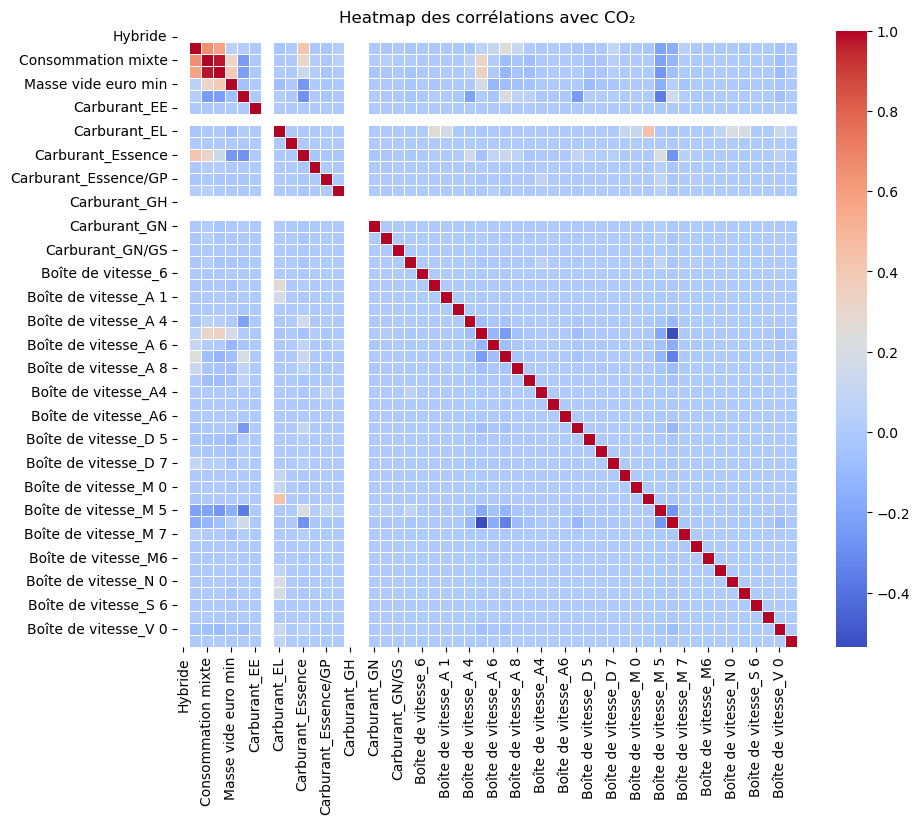

In [182]:
# Heatmap des corrélations avec CO2

plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=False, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap des corrélations avec CO₂")
plt.show()

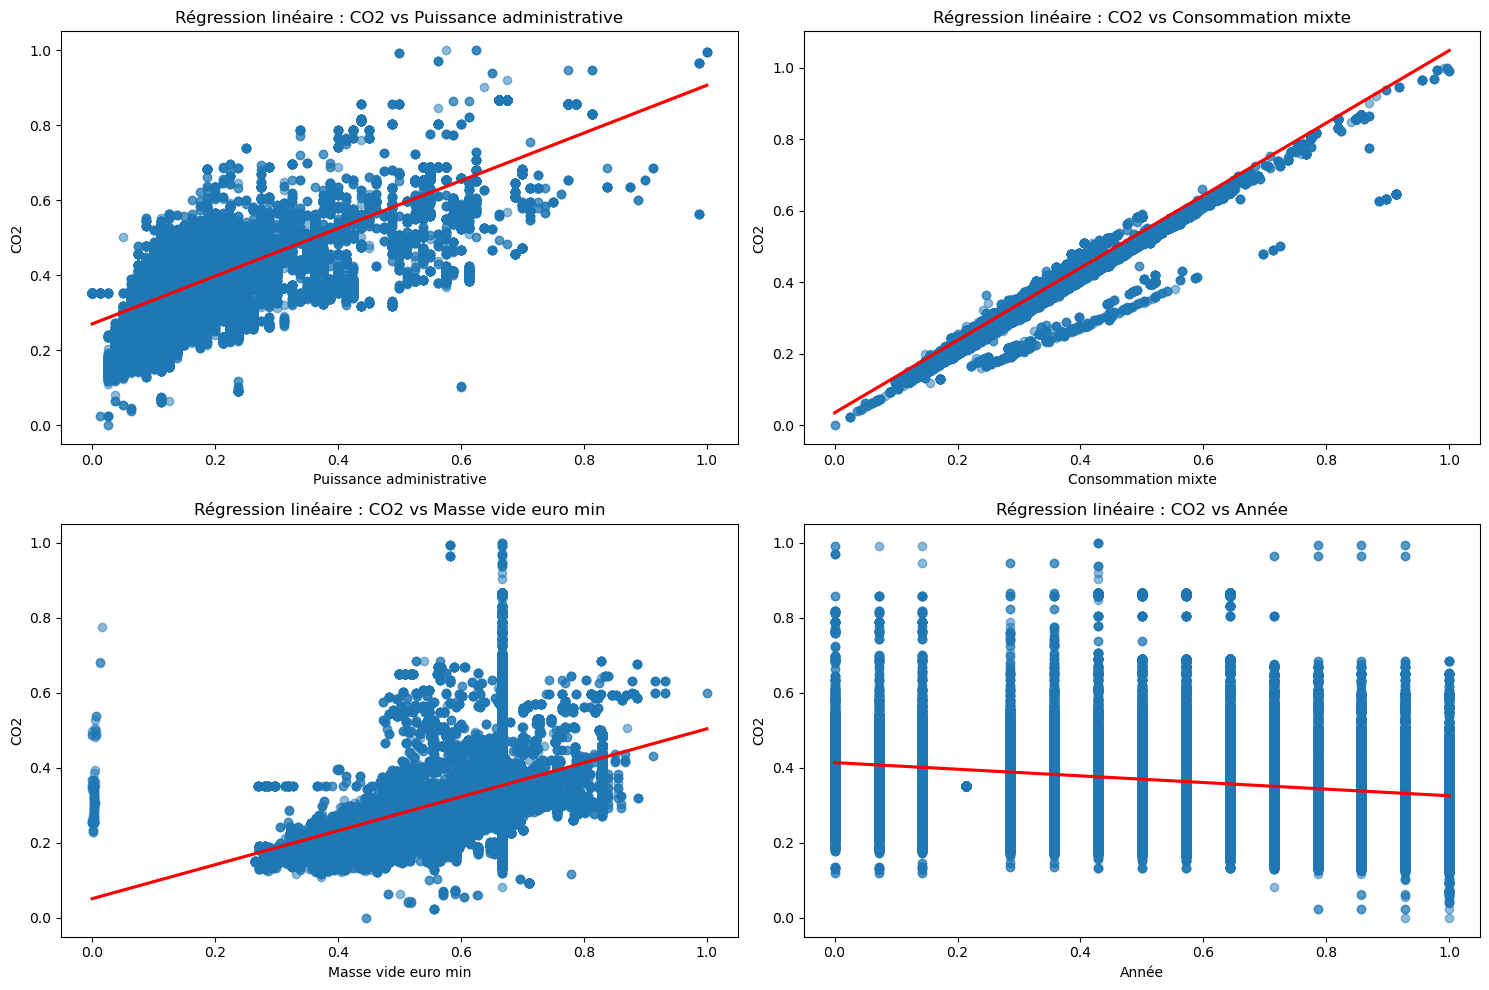

In [165]:
variables_explicatives = ["Puissance administrative", "Consommation mixte", "Masse vide euro min", "Année"]

plt.figure(figsize=(15, 10))
for i, col in enumerate(variables_explicatives):
    plt.subplot(2, 2, i + 1)
    sns.regplot(data=df, x=col, y="CO2", scatter_kws={'alpha':0.5}, line_kws={"color":"red"})
    plt.title(f"Régression linéaire : CO2 vs {col}")
plt.tight_layout()
plt.show()

## Régression Linéaire

In [190]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df.drop('CO2', axis=1)

y = df['CO2']

# Diviser les données en un jeu d'entraînement et un jeu de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Création du modèle de régression linéaire
model = LinearRegression()

# Entraînement du modèle
model.fit(X_train, y_train)

# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Évaluation du modèle
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error (MSE) : {mse}')

# Calcul du coefficient de détermination R²
r2_score = model.score(X_test, y_test)
print(f'Coefficient de détermination R² : {r2_score}')

Mean Squared Error (MSE) : 4.787995738567287e-05
Coefficient de détermination R² : 0.9941024664160162


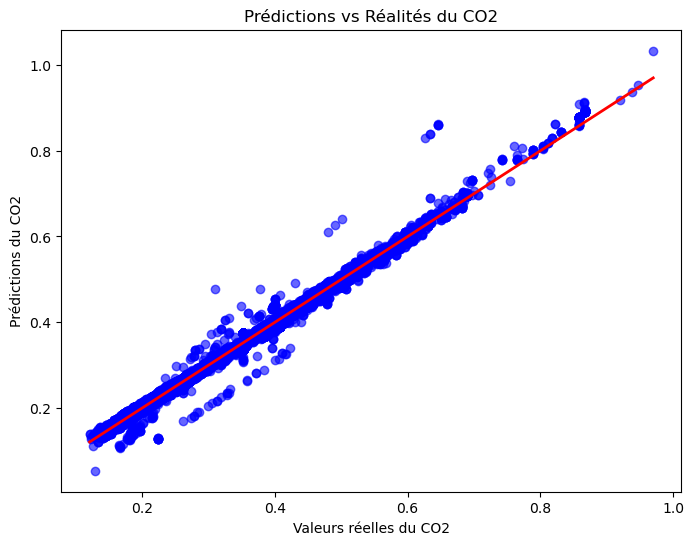

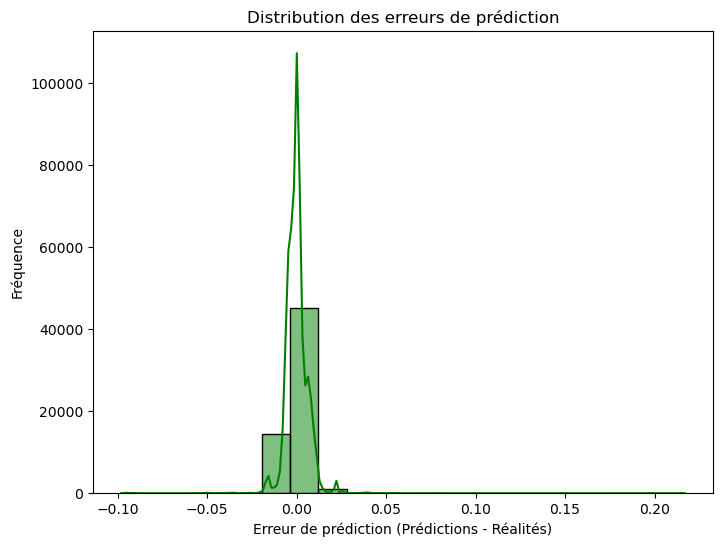

In [191]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Visualisation des prédictions vs valeurs réelles
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linewidth=2)
plt.title('Prédictions vs Réalités du CO2')
plt.xlabel('Valeurs réelles du CO2')
plt.ylabel('Prédictions du CO2')
plt.show()

# Visualisation de l'erreur de prédiction
plt.figure(figsize=(8, 6))
errors = y_pred - y_test
sns.histplot(errors, kde=True, color='green', bins=20)
plt.title('Distribution des erreurs de prédiction')
plt.xlabel('Erreur de prédiction (Prédictions - Réalités)')
plt.ylabel('Fréquence')
plt.show()